# Tutorial for quante_carlo
- <b>quante_carlo</b> is a multiprocess hyperparameter tuning module. 
- This notebook demonstrates how to use this module to determine the number of neurons to use in a pytorch neural network.

In [3]:
#from sklearn.model_selection import cross_val_score
import pandas as pd
#from quante_carlo import quante
import quante
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
import time
import numpy as np
import torch
import multiprocessing as mp
#from multiprocessing.pool import ThreadPool as tp
from torch import nn
import worker

In [2]:
cd ../quante_carlo

/home/ec2-user/SageMaker/projects/quante_carlo/quante_carlo


## This tutorial uses mnist dataset available <a href="https://www.kaggle.com/code/imdevskp/digits-mnist-classification-using-cnn">here</a>

### Multiprocessing
Note to person giving demo:
    <code>gunicorn -w 18 'flask_worker:app'</code>

Included with this repository is a file named worked.py. It's better to put the objective function you want to optimize in a file.
<br> In this example, the worker.py file defines an evaluation function called instance


    def instance(p):
        loss_fn = torch.nn.BCEWithLogitsLoss()
        device = 'cuda:'+str(p['thread_id'])
        model = NeuralNetwork(p['input_layer_size'], p['hparameters'], n_outputs=p['output_layer_size'])
        model.to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        loss_history = []
        model.train()

        loader = data_loader(p['batch_size'])

        for i in range(p['train_iterations']):
            for batch in range(p['n_batches']):
                X_train, y_train = loader.get_batch(batch)

                X = X_train.to(device)
                y = y_train.to(device)

                pred = model(X)
                loss = loss_fn(pred, y)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss_history.append(loss.item())

        X_test, y_test = loader.get_batch(-1)

        model.eval()

        X = X_test.to(device)
        y = y_test.to(device)
        pred = model(X)

        torch.cuda.empty_cache()

        return 1-loss.item()



- The function takes the parameters for each instance from a field defined by the key 'hparameters'.
- The function also returns 1 - loss because the NeuralNetwork is minimizing loss and the Optimizer is set to 'maximize' the function.


### Main 
- The network has 3 hidden layers and the ranges of each layer are as follows: [[32, 512], [32, 1024], [32, 512]],
- Notice that there are 16 gpr processors (Bayesian Optimization step) and 4 GPU processers (training step)
- Because the output layer is a vector of length 10 of ones and zeros we are using BCEWithLogitsLoss.
- I am not using a softmax final function because for prediction, it seems to perform better without one.

In [5]:

gbatch_size = 5000
g_procs = 18 # cpus
hp_ranges = [[32, 512], [32, 1024], [32, 512]]
n_procs = 3 # number of gpus
n_iter = 20 # bayes iterations
logfile_name = 'logs/logfile_14.txt'


oparameters = {'input_layer_size': 28*28, 
               'output_layer_size': 10, 
               'train_iterations': 200,
               'n_batches': 11,
               'batch_size': .06}


if __name__ == '__main__':

    
    hp_tune = quante.carlo(worker.instance, limits=hp_ranges, 
                           #kernel=DotProduct()+ WhiteKernel(), 
                           gpr_batch_size=gbatch_size, n_gpr_processors=g_procs, n_processors=n_procs, n_iterations=n_iter, 
                           other_parameters = oparameters, log_file=logfile_name)
    p = mp.Pool()
    #p = tp.ThreadPool(g_procs)
    start = time.time()    
    session = hp_tune(p)

    print("{} seconds".format(round(time.time() - start,2)))
    p.close()
    

419.41 seconds


In [6]:
summary = session.summary()
summary

,iteration,score,hparameters,qEi
0,0,0.922961,"(344, 164, 38)",-1.000000
1,0,0.927925,"(286, 234, 95)",-1.000000
2,0,0.943128,"(337, 923, 333)",-1.000000
3,1,0.937583,"(496, 998, 56)",0.999999
4,1,0.941063,"(491, 194, 400)",0.999999
...,...,...,...,...
58,19,0.944529,"(313, 1003, 473)",0.412563
59,19,0.947960,"(497, 1010, 504)",0.412563
60,20,0.938212,"(255, 526, 135)",0.436195
61,20,0.946609,"(486, 1019, 507)",0.436195


In [7]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


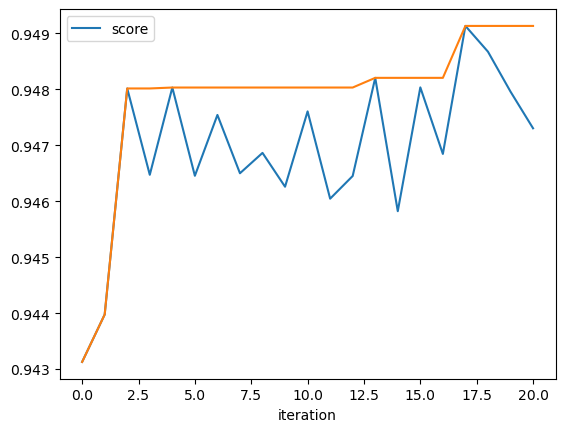

In [8]:
n = summary[['score', 'iteration']].groupby('iteration').max().plot()
best = [max(summary[summary['iteration']<=i]['score']) for i in range(n_iter+1)]
p = plt.plot(best)
plt.savefig('hptune.png')

In [12]:
import neptune
run = neptune.init_run(
    project="mshipman/HPTune",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNzhiNTgwMC05MDAzLTQ4NTQtOTk1NC04YWFlN2JkMDg4NWEifQ==",
)

summary.to_csv("summary.csv", index=False)
run["summary/score_history.csv"].upload("summary.csv")

params = {"limits": '('+') ('.join(["{},{}".format(x[0], x[1]) for x in hp_ranges])+')', 
          "gpr_batch_size": gbatch_size,
          "n_gpr_processors": g_procs, "n_processors": n_procs,
          "n_iterations": n_iter, "other_parameters": oparameters}
run["parameters"] = params
run["summary/best_by_iteration.png"].upload("hptune.png")
run['historical/best'] = ','.join([str(x) for x in best])
run["log"].upload(logfile_name)
run.stop()


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mshipman/HPTune/e/HPTUN-12
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 14 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/mshipman/HPTune/e/HPTUN-12/metadata
